# Schéma de Rusanov

En reprenant ce qui a été fait au cours du TP2 et en suivant les étapes détaillées dans l'annexes, nous allons reconstuire la solution du problème de la
dynamique des gaz compressibles isothermes : :

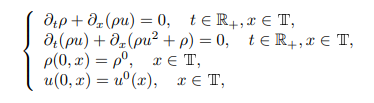

En suivant, nous intégrerons ce champs de vitesse variable dans le schéma utilisant le réseau de neurone stocké dans le 'model2'

In [1]:
import numpy as np
import  matplotlib.pyplot  as plt

In [2]:
def Rusanov(u, a, dt, dx, c):
    ''' Schéma de Rusanov vu en TP '''
    u_flux = np.empty(u.size + 1)
    u_flux[1:-1] = 0.5 * (u[:-1] + u[1:]) + c / (2 * a) * (u[:-1] - u[1:])

    # conditions périodique
    u_flux[-1] = 0.5 * (u[-1] + u[0]) + c / (2 * a) * (u[-1] - u[0])
    u_flux[0] = u_flux[-1]

    u -= a * dt / dx * (u_flux[1:] - u_flux[:-1])

## 2 .Ecrire une fonction $\rho_0(x)$ et une fonction $u_0(x)$ qui retournent des tableaux contenant les conditions  initiales.  


In [3]:
def rho0_0(x):
    '''    Retourne les conditions initiales rho0(x)    '''
    return(np.ones(len(x)))

def rho0_1(x):
    r0 = np.ones(len(x))
    r0[x<=1/2]+=1
    return(r0)

In [4]:
x=np.linspace(0,1,10)
print(rho0_0(x))
print(rho0_1(x))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[2. 2. 2. 2. 2. 1. 1. 1. 1. 1.]


In [5]:
'''    Retourne les conditions initiales u0(x) '''

def u0_0(x):
    return(np.ones(len(x)))

def u0_1(x):
    return(np.zeros(len(x)))

### 3. ́Ecrire une fonction compute_rs(rho, u) qui retourne le rayon spectral de la jacobienne du système en U, $rs(U)$.

In [6]:
# Question 3
def compute_rs(rho, u):
    '''     Retourne le rayon spectral rs de la jacobienne, soit la plus grande v.p en valeur absolue   '''
    return max(np.amax(np.abs(u - 1)), np.amax(np.abs(u +1))) # remplacer 1 par sqrt de rho ?


### 4. ́Ecrire une fonction compute_fluxes(rho, u, rs)
La fonction retourne un tableau contenant les flux $F^n_{j+1/2}$ pour $j= 0,...,J$. On utilise les conditions de bord periodiques comme indiqué dans le sujet.


In [7]:
# Question 4
def compute_fluxes(rho, u, rs):
    ''' selon la même syntaxe que vu dans le TP2 je génère les flux '''
    fl = np.empty((2, u.size + 1))
    fU = F(rho, u)
    # On renvoi F^n _ j+1/2 
    fl[0, 1:-1] = 0.5 * (fU[0, :-1] + fU[0, 1:]) - 0.5 * rs * (rho[1:] -rho[:-1])
    fl[1, 1:-1] = 0.5 * (fU[1, :-1] + fU[1, 1:]) - 0.5 * rs *(rho[1:]*u[1:] - rho[:-1]*u[:-1])


    # Conditions périodiques : mes vitesses excèdent 1 en valeur absolue

    #fl[0, 0] = fU[0,-1]
    #fl[1, 0] = fU[1,-1]


     # mur - Je prend ces conditions afin de conserver des vitesses entre [-1 et 1]
    # On prend h_0 = h_1, u_0 = -u_1 et h_{J+1} = h_J, u_{J+1} = -u_J
    q= rho*u
    fl[0, 0] = 0
    fl[0, -1] = 0
    fl[1, 0] = fU[1, 0] - rs * q[0]
    fl[1, -1] = fU[1, -1] + rs * q[-1]

    
    return fl

Je choisis ici d'utiliser les conditions aux bords "mur" car je n'arrive pas à obtenir une solution u compatible avec notre schéma à vitesse signée avec les conditions périodiques. 
Plus simplement, cela me permet d'obtenir des vitesses n'excédant pas 1 en valeur absolue.

In [8]:
def F(rho,u):
    ''' En reprenant les équations '''
    f=np.empty((2,u.size))
    f[0,:] = rho * u
    f[1,:] = rho*u**2 + rho
    return f


### 5.  Resoudre les ́equations d’Euler de manière approchee en utilisant le schema de Rusanov


0.19191919191919193
99


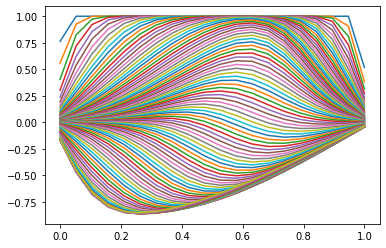

In [9]:
# Question 5
#g = 1
N_x = 20
x = np.linspace(0,1,N_x)
dx = 1/(N_x -1)

N_t = 100 #il faut prendre un pas de temps très petit pour avoir la convergence du schéma
dt = 1/(N_t-1)

t = 0
#T = 1

rho = rho0_0(x)
u = u0_0(x)
q = rho * u
rs = compute_rs(rho, u)
rsC = 0.5

sol = np.empty((N_t,N_x))
i=0
cfl =  2*rsC*dt/dx
print(cfl)
# boucle en temps
while (cfl < 1) & (i < N_t-1):
    i=i+1
    # rayon spectral
    rs = compute_rs(rho, u)

    # condition CFL à chaque pas de temps
    #dt = min(T - t, rsC * dx / np.amax(rs))
    #print(dt)
    t += dt

    # F_{j+1/2}, j = 0, ..., J
    fluxes = compute_fluxes(rho, u, rs)

    # schéma de Rusanov
    rho -= dt * (fluxes[0, 1:] - fluxes[0, :-1]) / dx
    q -= dt * (fluxes[1, 1:] - fluxes[1, :-1]) / dx #q = rho* u 
    

    # calcul de la vitesse u = rho u / rho si rho > 0, 0 sinon
    mask = rho > 1e-10
    u[mask] = q[mask] / rho[mask]
    u[np.logical_not(mask)] = 0
    sol[i,:] = u
    cfl =2*rs*dt/dx # Comme précisé dans le sujet le pas de temps ∆t dépend de l’itération n et il faudrait réécrire le schéma en remplaçant ∆t par ∆t^n
    
    # mise à jour du plot
    plt.plot(x,u)
print(i)    

J'obtiens ici une solution négative :

In [10]:
u

array([-0.16004311, -0.44967833, -0.66213486, -0.78621231, -0.84140545,
       -0.85345438, -0.84014075, -0.81110317, -0.77126815, -0.72332942,
       -0.66898853, -0.60948538, -0.54580738, -0.47877185, -0.40906415,
       -0.33726219, -0.26385688, -0.18927102, -0.11387655, -0.0380105 ])

Ce qui ne nous arrange pas car il est difficile d'en faire l'étude sur notre schéma avec vitesse signée.

En utilisant les autres conditions initiales :

0.19191919191919193
99


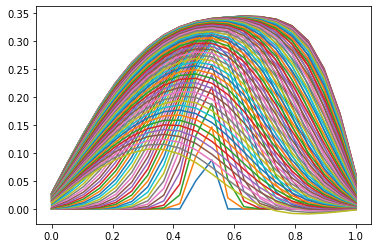

In [11]:
N_x = 20
x = np.linspace(0,1,N_x)
dx = 1/(N_x -1)

N_t = 100 #il faut prendre un pas de temps très petit pour avoir la convergence du schéma
dt = 1/(N_t-1)

t = 0
#T = 1

rho = rho0_1(x)
u = u0_1(x)
q = rho * u
rs = compute_rs(rho, u)
rsC = 0.5

sol = np.empty((N_t,N_x))
i=0
cfl =  2*rsC*dt/dx
print(cfl)
# boucle en temps
while (cfl < 1) & (i < N_t-1):
    i=i+1
    # rayon spectral
    rs = compute_rs(rho, u)
    t += dt

    # F_{j+1/2}, j = 0, ..., J
    fluxes = compute_fluxes(rho, u, rs)

    # schéma de Rusanov
    rho -= dt * (fluxes[0, 1:] - fluxes[0, :-1]) / dx
    q -= dt * (fluxes[1, 1:] - fluxes[1, :-1]) / dx #q = rho* u  

    # calcul de la vitesse u = rho u / rho si rho > 0, 0 sinon
    mask = rho > 1e-10
    u[mask] = q[mask] / rho[mask]
    u[np.logical_not(mask)] = 0
    sol[i,:] = u
    cfl =2*rs*dt/dx  
    # mise à jour du plot
    plt.plot(x,u)
print(i)    

In [12]:
u_rusanov = u

In [13]:
u_rusanov

array([ 0.01096787,  0.03260304,  0.05328632,  0.07221731,  0.08836099,
        0.1004109 ,  0.10687331,  0.10636583,  0.09816857,  0.0828669 ,
        0.06266904,  0.04098797,  0.02135243,  0.0062643 , -0.0033569 ,
       -0.00798922, -0.00888994, -0.00745453, -0.00480281, -0.00164364])

On peut désormais intégrer la solution du problème à notre schéma avec vitesse positive : 

In [14]:
import tensorflow as tf

2022-03-23 17:18:56.829972: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-23 17:18:56.830036: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [15]:
model = tf.keras.models.load_model('model2')

2022-03-23 17:18:59.564200: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-23 17:18:59.564264: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-23 17:18:59.564305: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (newtown): /proc/driver/nvidia/version does not exist


In [16]:
N_t = N_t
N_x = N_x
dt= 1/(N_t-1)
dx=1/(N_x-1) 
x=np.linspace(0,1,N_x)
# integration de la solution
t= dt
a0 = u_rusanov

#Pour commencer
predict_1 =model.predict(np.append(a0[0:3],u[0]*dt/dx).reshape(1,4))
alpha=np.zeros((N_t,N_x))
alpha[0,:]=a0 

In [17]:
n=1
cfl = max(a0)*dt/dx
print(cfl)
pred = predict_1[0,:] #les trois qté de matière pour premiere maille
stock = 0 #pred[0] Je me le permet ici car on a 0 quantité de matière dans la premiere maille.
pred = pred[1]
while cfl<1 and n<N_t-1: # La condition cfl doit être controlée pour continuer les itérations
    if n%10==1:
        print(n) #Pour suivi du temps d'exécution
    for i in range(0,N_x-2): 
        alpha[n,i+1]=alpha[n-1,i] - pred + stock      
        #Je prédis la quantité de matière sortante de la maille suivante
        stock = pred
        pred = model.predict(np.append(alpha[n-1,i:][0:3],u[i]*dt/dx).reshape(1,4))[0,:][1] 
    cfl = max(alpha[n,:])*dt/dx
    #Conditions bords :Si on veut les conditions périodiques : alpha[n,0]= alpha[n,N_x-1] 
    n=n+1
    alpha[n,0]=alpha[n-1,N_x-2] # Pour forcer le passage du bord 
    alpha[n,1]=alpha[n-1,N_x-1] 
    u=alpha[n-1,:]
    t+=dt
X = np.linspace(0,1,N_x)

0.0205110383653048
1
11
21
31
41
51
61
71
81
91


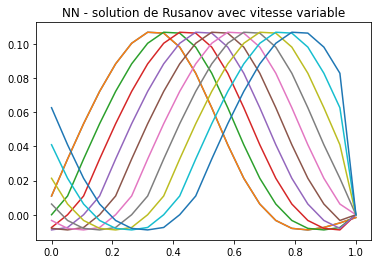

In [18]:
plt.plot(X,alpha[0,:])
plt.title("NN - solution de Rusanov avec vitesse variable")
l=[]
for i in range(0,n-1):
   if i<10 :
    plt.plot(X,alpha[i,:])

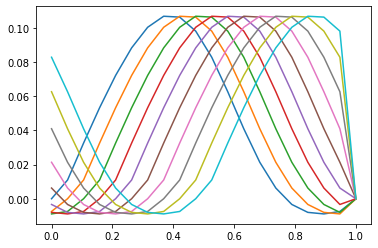

In [19]:
for i in range(20,30):plt.plot(X,alpha[i,:])

On voit ici que la quantité de matière est bien conservée ! Et que le schéma développé avec le réseau de neurones 'model2' fonctionne bien !

Nous avons réussi dans ce notebook à obtenir la solution du un système de la dynamique des gaz compressibles isothermes avec 2 conditions initiales différentes.
Il a été possible d'intégrer cette solution au schéma NN à vitesse variable dans le cas de la solution positive.